In [12]:
import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.neighbors import NearestNeighbors
from scipy import stats
from utils import *

from sklearn.naive_bayes import GaussianNB

import librosa
import librosa.display

import os
import multiprocessing

from tqdm import tqdm

data_path = 'data'
fma_small_path = 'data/fma_small'
fma_meta_path = 'data/fma_metadata'

duration_features = fma_load(f'{data_path}/duration_features2.csv')
features = fma_load(f'{data_path}/duration_features.csv')
tracks = fma_load(f'{data_path}/tracks_small.csv')

def get_id_from_duration_index(i):
    return i.split('-')[0]

In [13]:
train = tracks['set', 'split'] == 'training'
test = tracks['set', 'split'] == 'test'

In [14]:
# selected_tracks = ['{:06d}'.format(i) + '-30' for i in tracks.loc[test].head(40).index]
# row_numbers = [duration_features.index.get_loc(e) for e in selected_tracks]

selected_tracks = [i.split('-')[0] for i in features.index]
row_numbers = [tracks.index.get_loc(int(e)) for e in selected_tracks]
# print(selected_tracks)

# print(row_numbers)

In [21]:
# X_train = features.loc[train, 'mfcc']
# y_train = tracks.loc[train, ('track', 'genre_top')]

# X_test = features.loc[test, 'mfcc']
# y_test = tracks.loc[test, ('track', 'genre_top')]

#-------
# X_train = features['mfcc']
# y_train = tracks['track', 'genre_top']

# X_train = duration_features.iloc[row_numbers]['mfcc']
# y_train = tracks.loc[test].head(10)['track', 'genre_top']

# X_duration = duration_features['mfcc']
#-------


#-------
X_train = features
X_train.index = [int(e.split('-')[0]) for e in X_train.index]
X_train.index.name = 'track_id'
y_train = tracks['track', 'genre_top'].iloc[row_numbers]

# X_train = duration_features.iloc[row_numbers]
# y_train = tracks.loc[test].head(40)['track', 'genre_top']

X_duration = duration_features
#-------

# print(f'{y_train.size} training examples, {y_test.size} testing examples')
# print(f'{X_train.shape[1]} features, {np.unique(y_train).size} classes')

In [22]:
X_train.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
203           1.804127 -0.970386 -0.909323 -1.356279 -0.798477 -0.718077   
207          -0.222668  0.276971  0.630036  0.937292  0.248541  0.411537   
5            -0.565535 -0.483328 -1.312055 -0.400307 -0.260112 -0.500191   
204          -0.610849 -0.705878 -0.975263 -0.433307 -0.686569 -0.508129   
193          -0.701696  0.104534  2.697196  1.565533 -0.318205  0.593680   

feature                                              ...   tonnetz            \
statistics                                           ...       std             
number            07        08        09         10  ...        04        05   
track_id                                             ...                       
203         0.585195 -0.668285  4.549853  59.387005  ...  0.213865  0.070462   
207        -0.670764  0.324471 -1.471431  -0.759491  ...  0.298382  0.097898   
5          -0.788816  0.153193 -0.777737   2.737956  ...  0.111790  0.031011   
204        -0.486293  2.984654  5.081280   0.664252  ...  0.212296  0.064458   
193         2.652014 -1.018639 -0.249498   0.061181  ...  0.162640  0.077171   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
203         0.069626  11.295333  0.112305  0.027046  0.025391  0.010254   
207         0.080059   5.966227  0.162109  0.033954  0.028809  0.004883   
5           0.027161   6.147279  0.320801  0.059350  0.047852  0.002930   
204         0.055905  16.774931  0.343262  0.044073  0.031738  0.003906   
193         0.069941  33.604530  0.365234  0.042068  0.033203  0.010254   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
203         2.433081  0.010573  
207         2.130971  0.024602  
5           2.089969  0.047805  
204         4.036643  0.047256  
193         4.826024  0.030509  

[5 rows x 518 columns]

In [23]:
y_train.head()

track_id
203       Folk
207       Folk
5      Hip-Hop
204       Folk
193       Folk
Name: (track, genre_top), dtype: category
Categories (8, object): ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']

In [24]:
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=10)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
# scaler.fit_transform(X_train)
# scaler.transform(X_test)
# scaler.transform(X_duration)

In [25]:
clf = GaussianNB()
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_duration)
classes = clf.classes_

In [26]:
y_pred = clf.predict(X_train)
(X_train.shape[0], (y_train == y_pred).sum())

(4001, 1636)

In [27]:
frame_size = 1
whole_duration = 30
classes = clf.classes_
durations = list(range(frame_size, whole_duration+1, frame_size))
for tid in ['{:06d}'.format(i) for i in tracks.loc[test].head(400).index]:
    duration_predictions = pd.DataFrame(columns=classes)
    duration_predictions.index.name = 'time_second'
    for d in durations:
        id_d = f'{tid}-{d}'
        row_number = X_duration.index.get_loc(id_d)
        if (row_number >= 0):
            duration_predictions.loc[str(d)] = probs[row_number]
        else:
            print(f'error with {id_d}')
    duration_predictions.to_csv(f'{data_path}/duration_predictions/{tid}_dp.csv')

In [28]:
df = pd.read_csv(f'{data_path}/duration_predictions/069303_dp.csv', index_col=0)
df.head()

,Electronic,Experimental,Folk,Hip-Hop,Instrumental,International,Pop,Rock
time_second,,,,,,,,
1,0.000000e+00,1.000000e+00,1.535508e-119,0.000000e+00,2.805966e-139,0.000000e+00,0.000000e+00,0.000000e+00
2,1.180064e-102,9.351945e-05,3.281677e-54,0.000000e+00,9.999065e-01,8.028610e-91,1.869554e-85,1.957099e-238
3,6.686777e-109,1.000000e+00,5.032347e-59,0.000000e+00,1.163170e-14,2.605769e-121,1.191796e-97,1.665925e-246
4,2.274436e-78,9.846894e-23,1.973464e-26,1.168491e-242,1.000000e+00,3.968789e-42,8.033934e-53,1.435330e-177
5,7.027592e-53,4.146593e-30,3.532792e-11,6.828951e-139,1.000000e+00,6.658146e-20,1.836553e-23,1.307782e-93


<AxesSubplot:xlabel='track_id'>

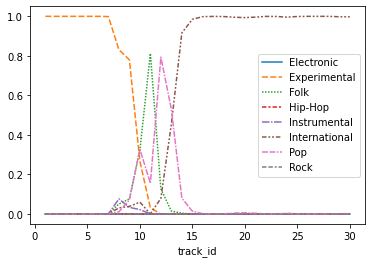

In [124]:
# df.drop(['International'], axis=1)
sns.lineplot(data=df)

In [125]:
tracks.loc[test, ('track', 'genre_top')]

track_id
182                Rock
704       International
705       International
706       International
707       International
              ...      
154305          Hip-Hop
154306          Hip-Hop
154307          Hip-Hop
154308          Hip-Hop
154309          Hip-Hop
Name: (track, genre_top), Length: 800, dtype: category
Categories (8, object): ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']

In [103]:
X_train[X_train.index == 69303]

feature    chroma_cens                                                  \
statistics    kurtosis                                                   
number              01        02       03        04       05        06   
track_id                                                                 
69303         0.874141 -0.591869 -1.06513 -0.982365 -0.76409 -1.339698   

feature                                           ...   tonnetz            \
statistics                                        ...       std             
number           07       08        09        10  ...        04        05   
track_id                                          ...                       
69303      -1.19303  0.39745 -0.173876  0.668591  ...  0.174363  0.119029   

feature                    zcr                                              \
statistics            kurtosis       max      mean    median  min     skew   
number            06        01        01        01        01   01       01   
track_id                                                                     
69303       0.106502 -0.795594  0.158691  0.067229  0.070068  0.0 -0.03216   

feature               
statistics       std  
number            01  
track_id              
69303       0.034475  

[1 rows x 518 columns]

In [104]:
X_duration[X_duration.index == '069303-30']

feature    chroma_cens                                                  \
statistics    kurtosis                                                   
number              01        02       03        04       05        06   
069303-30     0.874141 -0.591869 -1.06513 -0.982365 -0.76409 -1.339698   

feature                                           ...   tonnetz            \
statistics                                        ...       std             
number           07       08        09        10  ...        04        05   
069303-30  -1.19303  0.39745 -0.173876  0.668591  ...  0.174363  0.119029   

feature                    zcr                                              \
statistics            kurtosis       max      mean    median  min     skew   
number            06        01        01        01        01   01       01   
069303-30   0.106502 -0.795594  0.158691  0.067229  0.070068  0.0 -0.03216   

feature               
statistics       std  
number            01  
069303-30   0.034475  

[1 rows x 518 columns]

In [105]:
tracks['track', 'genre_top'][tracks.index == 69303]

track_id
69303    Experimental
Name: (track, genre_top), dtype: category
Categories (8, object): ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']

In [106]:
y_train[y_train.index == 69303]

track_id
69303    Experimental
Name: (track, genre_top), dtype: category
Categories (8, object): ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']

In [107]:
prob = clf.predict_proba(X_train[X_train.index == 69303])
print(classes)
print(prob)

['Electronic' 'Experimental' 'Folk' 'Hip-Hop' 'Instrumental'
 'International' 'Pop' 'Rock']
[[4.16000783e-40 3.24494882e-66 3.85685057e-14 6.02722703e-46
  2.22404078e-11 9.99995331e-01 4.66899943e-06 2.57595201e-50]]


<AxesSubplot:>

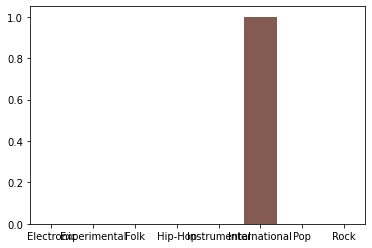

In [108]:
sns.barplot(x=classes, y=prob[0])